In [1]:

import datetime as dt
import json
import logging
import math

import astropy.time as astt
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import requests
from astropy.table import Table
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats

logging.getLogger('matplotlib').setLevel(logging.FATAL)

plt.rcParams["figure.figsize"] = (20, 34)
plt.style.use('ggplot')

log = logging.getLogger(__name__)
logging.basicConfig(level=getattr(logging,'INFO'), format='%(asctime)s.%(msecs).03d %(levelname)7s: %(module)20s: %(message)s')

In [2]:
def get_nres_radialvelocities(object='HD126053', after=dt.datetime (year=2025, month=4, day=1), before=dt.datetime.now()):
    """Get focus-relevant fits header keywords for end of focus exposures,
       as a proxy for the ideally focused telescope state """

   

    sourcecolumn = ['OBJECT', 'RV', 'RVERR',  'DATE-OBS', 'DAY-OBS', 'ORIGNAME',
                    'WMSTEMP', 'CCDATEMP', 'SUNALT', 'SITEID',  'BARYCORR', ]

    log.info(f"Selecting after date: {after}")

    query = f'PROPID:"NRES standards" AND GROUPID:"NRES RV" AND OBSTYPE:TARGET' \
            f' AND OBJECT:{object} AND _exists_:RV AND RLEVEL:92'\
            f' AND DATE-OBS:[{after.strftime("%Y-%m-%dT%H:%M:%S")} TO {before.strftime("%Y-%m-%dT%H:%M:%S")}]'

    log.info(f"Query: {query}")
    body = {
        "size": 10000,
        "_source": sourcecolumn,
        "query": {
            "query_string": {
                "query": query
            }
        }
    }

    headers = {'Content-type': 'application/json'}
    response = requests.get('https://opensearch.lco.global:443/fitsheaders/_search',
                            data=json.dumps(body), headers=headers).json()
    # make a nice table out of that convoluted mess
    intermediate = [r['_source'] for r in response['hits']['hits']]
    t = [[item[col] for col in sourcecolumn] for item in intermediate]
    t = np.asarray(t)
    log.info(f"Number of raw records {len(t)}")
    if len(t) == 0:
        log.warning("Warning: empty return for {} {} {}".format(site, enc, tel))
        return None

    # reformatting boilerplate stuff
    dayobsidx = sourcecolumn.index('DAY-OBS')
    for ii in range(len(t)):
        t[ii, dayobsidx] = "-".join([t[ii, dayobsidx][0:4], t[ii, dayobsidx][4:6],
                                     t[ii, dayobsidx][6:8]])

    try:
        dtypes = [float for ii in range(len(sourcecolumn))]
        dtypes[sourcecolumn.index('DATE-OBS')] = str
        dtypes[sourcecolumn.index('DAY-OBS')] = str
        dtypes[sourcecolumn.index('ORIGNAME')] = str
        dtypes[sourcecolumn.index('OBJECT')] = str
        dtypes[sourcecolumn.index('SITEID')] = str
        t = Table(t, names=sourcecolumn,
                  dtype=dtypes)
        t['DATE-OBS'] = astt.Time(t['DATE-OBS'], scale='utc', format=None).to_datetime()
        t['DAY-OBS'] = astt.Time(t['DAY-OBS'], scale='utc', format=None).to_datetime()
    except:
        log.exception("Error parsing opensearch return")
        return None

    fullsize = len(t)
    t.sort('DATE-OBS')
    t = t[t['RVERR'] < 100]

    log.info(f"Number of sanitized records: {len(t)} / {fullsize}")
    return t


data = get_nres_radialvelocities()

2025-09-05 15:32:26,540.540    INFO:           3817361866: Selecting after date: 2025-04-01 00:00:00
2025-09-05 15:32:26,540.540    INFO:           3817361866: Query: PROPID:"NRES standards" AND GROUPID:"NRES RV" AND OBSTYPE:TARGET AND OBJECT:HD126053 AND _exists_:RV AND RLEVEL:92 AND DATE-OBS:[2025-04-01T00:00:00 TO 2025-09-05T15:32:26]
2025-09-05 15:32:28,298.298    INFO:           3817361866: Number of raw records 444
2025-09-05 15:32:28,304.304    INFO:           3817361866: Number of sanitized records: 438 / 444


Text(0.5, 1.0, 'HD126053')

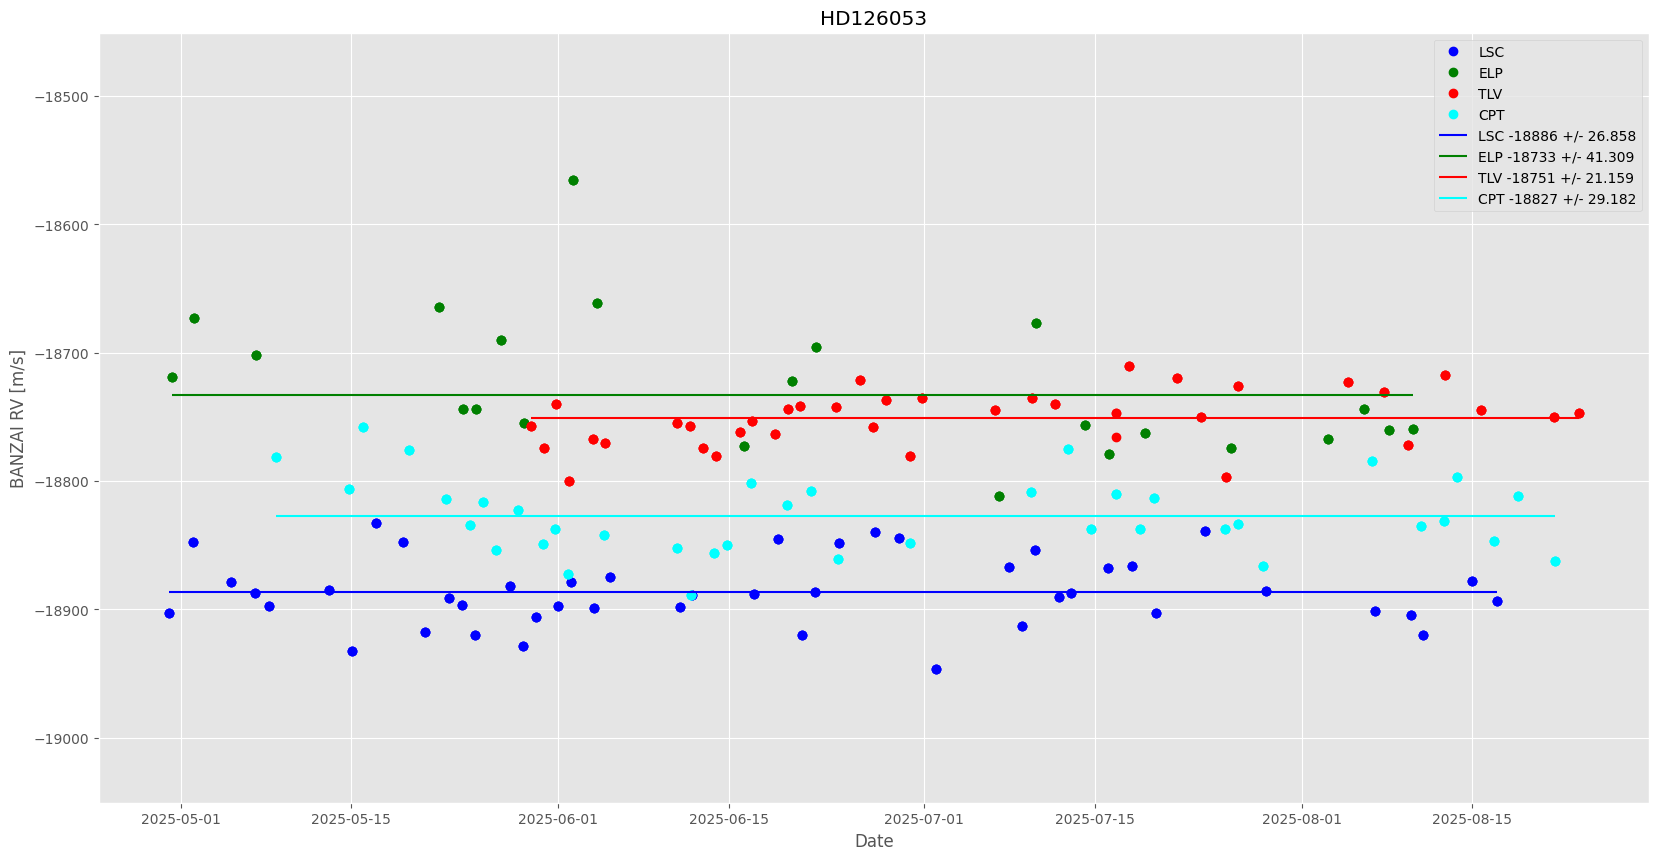

In [3]:
# Plot RV vs time, seperated by site

tlvselect = data['SITEID' ]== 'tlv'
lscselect = data['SITEID' ]== 'lsc'
cptselect = data['SITEID' ]== 'cpt'
elpselect = data['SITEID' ]== 'elp'

plt.figure(figsize=(20, 10))

plt.plot (data['DATE-OBS'][lscselect], data['RV'][lscselect], 'o', color='blue', label='LSC' )
plt.plot (data['DATE-OBS'][elpselect], data['RV'][elpselect], 'o', color='green', label='ELP' )
plt.plot (data['DATE-OBS'][tlvselect], data['RV'][tlvselect], 'o', color='red', label='TLV' )
plt.plot (data['DATE-OBS'][cptselect], data['RV'][cptselect], 'o', color='cyan', label='CPT' )




meanlsc, medianlsc,stddevlsc = sigma_clipped_stats(data['RV'][lscselect])
meanelp,a,stddevelp = sigma_clipped_stats(data['RV'][elpselect])
meantlv,a,stddevtlv = sigma_clipped_stats(data['RV'][tlvselect])
meancpt,a,stddevcpt = sigma_clipped_stats(data['RV'][cptselect])

plt.hlines(meanlsc, xmin=data['DATE-OBS'][lscselect].min(), xmax=data['DATE-OBS'][lscselect].max(), color='blue', label=f'LSC {meanlsc:.0f} +/- {stddevlsc:.3f}')
plt.hlines(meanelp, xmin=data['DATE-OBS'][elpselect].min(), xmax=data['DATE-OBS'][elpselect].max(), color='green', label=f'ELP {meanelp:.0f} +/- {stddevelp:.3f}')
plt.hlines(meantlv, xmin=data['DATE-OBS'][tlvselect].min(), xmax=data['DATE-OBS'][tlvselect].max(), color='red',  label=f'TLV {meantlv:.0f} +/- {stddevtlv:.3f}')
plt.hlines(meancpt, xmin=data['DATE-OBS'][cptselect].min(), xmax=data['DATE-OBS'][cptselect].max(), color='cyan', label=f'CPT {meancpt:.0f} +/- {stddevcpt:.3f}')  

plt.xlabel('Date')
plt.ylabel ('BANZAI RV [m/s]')
plt.legend()
plt.ylim(meantlv - 300, meantlv + 300)
plt.title('HD126053')



In [4]:
plt.figure(figsize=(20, 10))
datum = 'WMSTEMP'
plt.plot (data['datum'][lscselect], data['RV'][lscselect], 'o', color='blue', label='LSC' )
plt.plot (data['datum'][elpselect], data['RV'][elpselect], 'o', color='green', label='ELP' )
plt.plot (data['datum'][tlvselect], data['RV'][tlvselect], 'o', color='red', label='TLV' )
plt.plot (data['datum'][cptselect], data['RV'][cptselect], 'o', color='cyan', label='CPT' )

KeyError: 'datum'

<Figure size 2000x1000 with 0 Axes>